**Forecasting using ARMA models**

### Libraries Imported

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product
from tqdm import tqdm_notebook
import warnings
from warnings import filterwarnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Uploading dataset


In [6]:
df=pd.read_csv('po_average_monthly.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column                                                                                      Non-Null Count  Dtype 
---  ------                                                                                      --------------  ----- 
 0   Month                                                                                       115 non-null    object
 1   Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114  115 non-null    object
dtypes: object(2)
memory usage: 1.9+ KB


In [7]:
df.describe()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
count,115,115
unique,115,112
top,1966-02,1152
freq,1,2


In [8]:
df.columns = ["month", "average_monthly_ridership"]

df.head()

,month,average_monthly_ridership
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [9]:
df['average_monthly_ridership'].unique()

array(['648', '646', '639', '654', '630', '622', '617', '613', '661',
       '695', '690', '707', '817', '839', '810', '789', '760', '724',
       '704', '691', '745', '803', '780', '761', '857', '907', '873',
       '910', '900', '880', '867', '854', '928', '1064', '1103', '1026',
       '1102', '1080', '1034', '1083', '1078', '1020', '984', '952',
       '1033', '1114', '1160', '1058', '1209', '1200', '1130', '1182',
       '1152', '1116', '1098', '1044', '1142', '1222', '1234', '1155',
       '1286', '1281', '1224', '1280', '1228', '1181', '1156', '1124',
       '1205', '1260', '1188', '1212', '1269', '1246', '1299', '1284',
       '1345', '1341', '1308', '1448', '1454', '1467', '1431', '1510',
       '1558', '1536', '1523', '1492', '1437', '1365', '1310', '1441',
       '1450', '1424', '1360', '1429', '1440', '1414', '1408', '1337',
       '1258', '1214', '1326', '1417', '1329', '1461', '1425', '1419',
       '1432', '1394', '1327', ' n=114'], dtype=object)

We can see here that this series consist an anamolous data which is the last one.

In [10]:
df = df.drop(df.index[df['average_monthly_ridership'] == ' n=114'])

Changing data type of both the column

* Assign int to monthly_ridership_data column
* Assign datetime to month column

In [11]:
df['average_monthly_ridership'] = df['average_monthly_ridership'].astype(np.int32)
df['month'] = pd.to_datetime(df['month'], format = '%Y-%m')

In [12]:
df.head()

,month,average_monthly_ridership
0,1960-01-01,648
1,1960-02-01,646
2,1960-03-01,639
3,1960-04-01,654
4,1960-05-01,630


### Stats and Plot

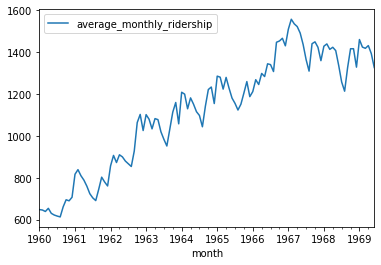

In [10]:
# Normal line plot so that we can see data variation
# We can observe that average number of riders is increasing most of the time
# We'll later see decomposed analysis of that curve
df.plot.line(x = 'month', y = 'average_monthly_ridership')
plt.show()




**First of all We need to check we need to check the stationarity of the time series using 3 tests**

In [11]:
from arch.unitroot import KPSS
from arch.unitroot import PhillipsPerron
from arch.unitroot import ADF

In [12]:
pp = PhillipsPerron(df['average_monthly_ridership'])
adf = ADF(df['average_monthly_ridership'])
kpss = KPSS(df['average_monthly_ridership'])
print(pp.summary().as_text())
print(adf.summary().as_text())
print(kpss.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.606
P-value                         0.481
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.537
P-value                         0.515
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  1.604
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null 














Here, all the three test collectively reject the hypothesis of time series data being stationary. so first we log tranform the data. Then we do differencing and perform these tests again. 

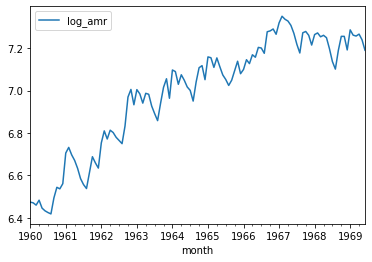

In [13]:
log_amr= np.log(df["average_monthly_ridership"])
df["log_amr"] = log_amr
df.plot.line(x = 'month', y = 'log_amr')


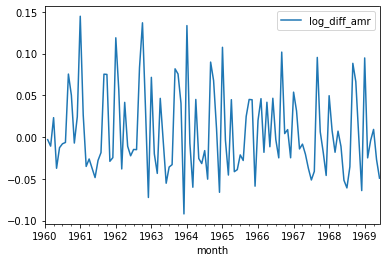

In [14]:
log_diff_amr = log_amr - log_amr.shift()
df["log_diff_amr"]=log_diff_amr
df.plot.line(x = 'month', y = 'log_diff_amr')

Visually we can somehow inspect the data is appears stationary. Anyways we perform tests again

In [15]:
df.head()

,month,average_monthly_ridership,log_amr,log_diff_amr
0,1960-01-01,648,6.473891,NaN
1,1960-02-01,646,6.470800,-0.003091
2,1960-03-01,639,6.459904,-0.010895
3,1960-04-01,654,6.483107,0.023203
4,1960-05-01,630,6.445720,-0.037388


In [19]:
dflog_diff_amr.dropna(inplace=True)

In [20]:
pp = PhillipsPerron(log_diff_amr)
adf = ADF(log_diff_amr)
kpss = KPSS(log_diff_amr)
print(pp.summary().as_text())
print(adf.summary().as_text())
print(kpss.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -11.597
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.048
P-value                         0.266
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.253
P-value                         0.184
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null 

2 out of 3 tests above, i.e. PP test and KPSS test confirm that now that the data is now weakly stationary. Hence we'll proceed for the forecasting analysis

In [24]:
order_list=[]
for p in range(0,7):
    for q in range (0,7):
        order_list.append((p,1,q))
        

        

In [25]:
AIC=[]
for i in order_list:
    try:
        model=ARIMA(df["log_amr"], order=i).fit(disp=False)
    except:
        continue
    aic = model.aic
    AIC.append((i,aic))

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist

In [28]:
AIC_df = pd.DataFrame(AIC)
AIC_df.columns = ['(p, d, q)', 'AIC']
AIC_df = AIC_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
AIC_df    

,"(p, d, q)",AIC
0,"(6, 1, 6)",-372.265959
1,"(4, 1, 4)",-365.380364
2,"(5, 1, 5)",-364.393583
3,"(5, 1, 2)",-363.951807
4,"(6, 1, 5)",-363.680912
5,"(5, 1, 6)",-363.266332
6,"(4, 1, 6)",-363.263249
7,"(3, 1, 3)",-361.566871
8,"(4, 1, 5)",-361.360615
9,"(2, 1, 3)",-360.293807


Due to computational limitation, I checked values of (p,q) within the range(0,7) We then selected the model with the lowest AIC score.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RSS: nan')

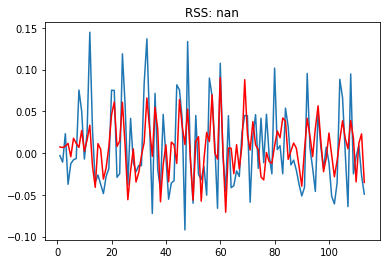

In [43]:
model = ARIMA(log_amr, order=(6, 1, 6))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_diff_amr)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_diff_amr)**2))

The forecast plot looks convincing and hence we proceed to actual forecasting. Since I had less data, I chose to forecast and plot the train data instead to visibly see the forecast curve

In [44]:
results_ARIMA.fittedvalues

1      0.007254
2      0.006596
3      0.008078
4      0.011498
5     -0.004403
         ...   
109    0.018090
110   -0.034501
111    0.011668
112    0.022920
113   -0.035152
Length: 113, dtype: float64

In [47]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

1    0.007254
2    0.006596
3    0.008078
4    0.011498
5   -0.004403
dtype: float64


This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [48]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df.iloc[0][2], index=df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()
#predictions_ARIMA_diff_cumsum.head()

1    0.007254
2    0.013850
3    0.021928
4    0.033426
5    0.029023
dtype: float64

Text(0.5, 1.0, 'RMSE: 183.2952')

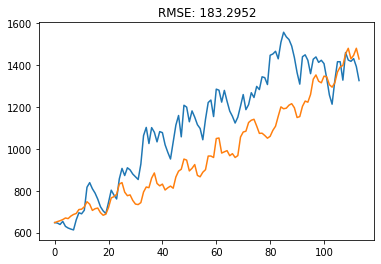

In [52]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df["average_monthly_ridership"])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df["average_monthly_ridership"])**2)/len(df)))

In [59]:
df["pred_AIC"]=predictions_ARIMA
df.head()

,month,average_monthly_ridership,log_amr,log_diff_amr,Sl.no,pred,pred_AIC
0,1960-01-01,648,6.473891,NaN,0,648.000000,648.000000
1,1960-02-01,646,6.470800,-0.003091,1,652.717623,652.123479
2,1960-03-01,639,6.459904,-0.010895,2,657.037239,656.273197
3,1960-04-01,654,6.483107,0.023203,3,662.366478,660.449321
4,1960-05-01,630,6.445720,-0.037388,4,670.026104,664.652020


In [60]:
df.drop(["pred"],axis=1,inplace=True)

## **$BIC$**

Similarly we proceed with BIC to chose the best model and forecast.

In [33]:
BIC=[]
for i in order_list:
    try:
        model=ARIMA(df["log_amr"], order=i).fit(disp=False)
    except:
        continue
    bic = model.bic
    BIC.append((i,bic))

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist

In [36]:
BIC_df = pd.DataFrame(BIC)
BIC_df.columns = ['(p, d, q)', 'BIC']
BIC_df = BIC_df.sort_values(by='BIC', ascending=True).reset_index(drop=True)
BIC_df 

,"(p, d, q)",BIC
0,"(0, 1, 0)",-342.952802
1,"(2, 1, 3)",-341.202092
2,"(0, 1, 2)",-340.860783
3,"(2, 1, 0)",-340.104211
4,"(3, 1, 3)",-339.747769
5,"(5, 1, 2)",-339.405316
6,"(4, 1, 2)",-338.364145
7,"(0, 1, 1)",-338.233822
8,"(1, 1, 0)",-338.229817
9,"(4, 1, 4)",-338.106485


Text(0.5, 1.0, 'RSS: nan')

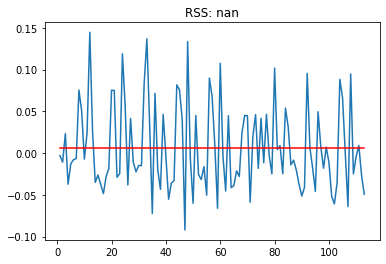

In [55]:
model = ARIMA(log_amr, order=(0, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_diff_amr)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_diff_amr)**2))

In [63]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

1    0.006343
2    0.006343
3    0.006343
4    0.006343
5    0.006343
dtype: float64


In [64]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df.iloc[0][2], index=df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()
#predictions_ARIMA_diff_cumsum.head()

0    6.473891
1    6.480234
2    6.486577
3    6.492920
4    6.499264
dtype: float64

Text(0.5, 1.0, 'RMSE: 211.2040')

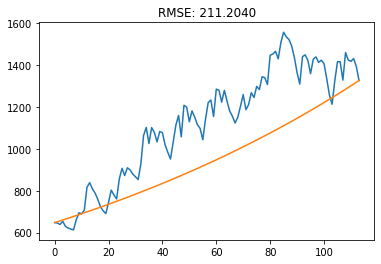

In [65]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df["average_monthly_ridership"])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df["average_monthly_ridership"])**2)/len(df)))